In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/harshitagarwal/Desktop/Kaggle Competitions/Predicting Loan Payback/train.csv')

In [3]:
df.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
df.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442236,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [6]:
val1 = df['gender'].unique()
val2 = df['marital_status'].unique()
val3 = df['education_level'].unique()
val4 = df['employment_status'].unique()
val5 = df['loan_purpose'].unique()
val6 = df['grade_subgrade'].unique()
print(val1)
print(val2)
print(val3)
print(val4)
print(val5)
print(val6)

['Female' 'Male' 'Other']
['Single' 'Married' 'Divorced' 'Widowed']
['High School' "Master's" "Bachelor's" 'PhD' 'Other']
['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


In [7]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cols = ['gender', 'marital_status', 'education_level', 'employment_status','loan_purpose', 'grade_subgrade']
df_arr = ohe.fit_transform(df[cols])
df_new = pd.DataFrame(df_arr, columns=ohe.get_feature_names_out(cols))
df_new.head(5)

,gender_Female,gender_Male,gender_Other,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Widowed,education_level_Bachelor's,education_level_High School,education_level_Master's,...,grade_subgrade_E1,grade_subgrade_E2,grade_subgrade_E3,grade_subgrade_E4,grade_subgrade_E5,grade_subgrade_F1,grade_subgrade_F2,grade_subgrade_F3,grade_subgrade_F4,grade_subgrade_F5
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_final = pd.concat([df.drop(['gender', 'marital_status', 'education_level', 
                               'employment_status', 'loan_purpose', 'grade_subgrade'], axis=1), 
                      df_new], axis=1)

In [9]:
df_final.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back,gender_Female,gender_Male,gender_Other,...,grade_subgrade_E1,grade_subgrade_E2,grade_subgrade_E3,grade_subgrade_E4,grade_subgrade_E5,grade_subgrade_F1,grade_subgrade_F2,grade_subgrade_F3,grade_subgrade_F4,grade_subgrade_F5
0,0,29367.99,0.084,736,2528.42,13.67,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,22108.02,0.166,636,4593.10,12.92,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,49566.20,0.097,694,17005.15,9.76,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,46858.25,0.065,533,4682.48,16.10,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,25496.70,0.053,665,12184.43,10.21,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_new.isnull().sum()

gender_Female                      0
gender_Male                        0
gender_Other                       0
marital_status_Divorced            0
marital_status_Married             0
marital_status_Single              0
marital_status_Widowed             0
education_level_Bachelor's         0
education_level_High School        0
education_level_Master's           0
education_level_Other              0
education_level_PhD                0
employment_status_Employed         0
employment_status_Retired          0
employment_status_Self-employed    0
employment_status_Student          0
employment_status_Unemployed       0
loan_purpose_Business              0
loan_purpose_Car                   0
loan_purpose_Debt consolidation    0
loan_purpose_Education             0
loan_purpose_Home                  0
loan_purpose_Medical               0
loan_purpose_Other                 0
loan_purpose_Vacation              0
grade_subgrade_A1                  0
grade_subgrade_A2                  0
g

In [11]:
df_final.corr(numeric_only=False)['loan_paid_back'].sort_values(ascending=False).head(50)

loan_paid_back                     1.000000
employment_status_Employed         0.421611
credit_score                       0.234560
employment_status_Retired          0.083526
employment_status_Self-employed    0.077374
grade_subgrade_B2                  0.055970
grade_subgrade_B3                  0.054583
grade_subgrade_B5                  0.052348
grade_subgrade_B4                  0.051289
grade_subgrade_C1                  0.048018
grade_subgrade_B1                  0.046116
grade_subgrade_C2                  0.041478
grade_subgrade_C5                  0.037161
grade_subgrade_C4                  0.036336
grade_subgrade_C3                  0.030711
grade_subgrade_A5                  0.023562
grade_subgrade_A3                  0.023086
grade_subgrade_A2                  0.022444
grade_subgrade_A4                  0.021157
grade_subgrade_A1                  0.019923
education_level_High School        0.018149
loan_purpose_Home                  0.017244
education_level_PhD             

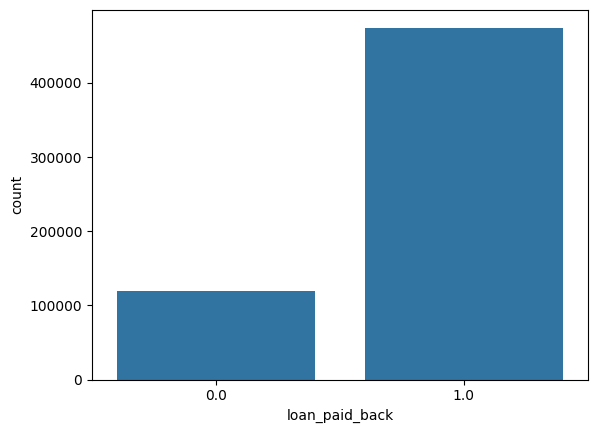

In [12]:
sns.countplot(data=df_final, x='loan_paid_back')
plt.show()

In [13]:
pd.set_option('display.max_rows', 20)

In [14]:
cred_score_pivot = df_final.pivot_table(index='credit_score', columns='loan_paid_back',aggfunc='count',values='id', fill_value=0)
cred_score_pivot.columns= ['no', 'yes']
cred_score_pivot['total'] = cred_score_pivot.sum(axis=1)
cred_score_pivot['Paid % vs Credit Score'] = round(cred_score_pivot['yes'] / cred_score_pivot['total']  * 100,1).astype(str) + '%'
cred_score_pivot.sort_index(ascending=False)

,no,yes,total,Paid % vs Credit Score
credit_score,,,,
849,5,66,71,93.0%
848,1,78,79,98.7%
847,2,104,106,98.1%
846,0,10,10,100.0%
845,0,92,92,100.0%
...,...,...,...,...
439,1,0,1,0.0%
437,0,3,3,100.0%
435,1,1,2,50.0%
